In [1]:
"""!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install torch
!pip install scikit-learn
!pip install torchvision
!pip install tqdm"""

'!pip install matplotlib\n!pip install numpy\n!pip install pandas\n!pip install seaborn\n!pip install torch\n!pip install scikit-learn\n!pip install torchvision\n!pip install tqdm'

In [2]:
import torch
import torch_directml
dml = torch_directml.device()
print(dml)
tensor1 = torch.tensor([1]).to(dml) # Note that dml is a variable, not a string!
tensor2 = torch.tensor([2]).to(dml)
dml_algebra = tensor1 + tensor2
print(dml_algebra.item())


privateuseone:0
3


In [3]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image, ImageFilter, ImageEnhance
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score
from torchvision import datasets, transforms
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from sklearn.model_selection import GridSearchCV
from torch.utils.data import Dataset, Subset
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.base import BaseEstimator, ClassifierMixin

Hyperparameters

In [4]:
class Hparams:
    def __init__(self, train_batch_size=64, test_batch_size=64, learning_rate=0.001, num_epochs = 10, val_split=0.2, test_split=0.2, model_path='saved_model', dataset_path='Data'):
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.val_split = val_split
        self.test_split = test_split
        self.model_path = model_path
        self.dataset_path = dataset_path

Dataset Loader

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset = None, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
            #mean = torch.mean(x)
            #std = torch.std(x)
        #return x, mean, std, y
        return x, y

    def __len__(self):
        return len(self.subset)

In [6]:
def get_transforms():
    transform = transforms.Compose([
        transforms.Resize((248, 248)),
        transforms.ToTensor(),
    ])
    return transform

In [7]:
def get_transforms_train():
    transform = transforms.Compose([
        transforms.Resize((248, 248)),
        transforms.RandomAffine(0, translate=None, scale= (0.8, 1.2), shear=None),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor()
    ])
    return transform

In [8]:
def get_sample_weights(dataset, train_dataset):

    # Code taken from:
    #     https://www.maskaravivek.com/post/pytorch-weighted-random-sampler/
    y_train_indices = train_dataset.indices
    print(train_dataset.indices)
    print(dataset.targets)
    y_train = [dataset.targets[i] for i in y_train_indices]

    class_sample_counts = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

    weights = 1. / class_sample_counts
    sample_weights = np.array([weights[t] for t in y_train])
    sample_weights = torch.from_numpy(sample_weights)

    return sample_weights

In [9]:
def get_data_loaders(hparams):
    # Loading the dataset
    dataset = datasets.ImageFolder(hparams.dataset_path,
                                   transform=transforms.Compose([transforms.Grayscale()]))

    # Splitting dataset into train, validation and test partitions.
    proportions = [(1 - hparams.val_split - hparams.test_split), hparams.val_split, hparams.test_split]
    lengths = [int(p * len(dataset)) for p in proportions]
    lengths[-1] = len(dataset) - sum(lengths[:-1])

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths)

    print(type(train_dataset))

    print(type(train_dataset[0][0]))

    print(f'train size: {lengths[0]}, val size: {lengths[1]}, test size: {lengths[2]}')

    data_transforms = {
        'train': get_transforms_train(),
        'test': get_transforms()
    }

    # Using WeightedRandomSampler to overcome unbalance problem
    sample_weights = get_sample_weights(dataset, train_dataset)
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights.type('torch.DoubleTensor'), len(sample_weights))

    train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = CustomDataset(val_dataset, transform=data_transforms['test'])
    test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])

    plt.imshow(train_dataset[0][0].moveaxis(0,2), cmap='gray') 

    # Creating loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.train_batch_size, sampler=train_sampler, drop_last=True, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams.train_batch_size, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.test_batch_size)

    return train_loader, val_loader, test_loader

In [10]:
from sklearn.model_selection import train_test_split

def get_split_dataset_loaders(hparams):

    folder_path = 'Data\\Mild Dementia'

    error = 3

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    image_names = [file for file in file_list]

    for i in range (len(image_names)):
        image_names[i] = image_names[i][:-14]

    uniqueID = pd.Series(image_names)
    uniqueID = uniqueID.unique()

    # Proportions you want to split into (e.g., 60% train, 20% validation, 20% test)
    train_proportion = 1 - hparams.val_split - hparams.test_split
    validation_proportion = hparams.val_split
    test_proportion = hparams.test_split

    # Perform the random split
    train_ID, temp_ID = train_test_split(uniqueID, train_size=train_proportion, random_state=42)
    validation_ID, test_ID = train_test_split(temp_ID, train_size=validation_proportion / (validation_proportion + test_proportion), random_state=42)

    dataset = datasets.ImageFolder(hparams.dataset_path,
                                   transform=transforms.Compose([transforms.Grayscale()]))

    index = 0
    location_change = [0]
    for i in range(len(dataset)):
        if (dataset[i][1] != index):
            location_change.append(i)
            index += 1

    train_index = []
    for i in range (len(train_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                if (filter_out(23, dataset[ii+location_change[0]][0])):
                    train_index.append(ii+location_change[0])
            
    val_index = []
    for i in range (len(validation_ID)):
        for ii in range (len(file_list)):
            if (validation_ID[i] in file_list[ii]):
                if (filter_out(23, dataset[ii+location_change[0]][0])):
                    val_index.append(ii+location_change[0])

    test_index = []
    for i in range (len(test_ID)):
        for ii in range (len(file_list)):
            if (test_ID[i] in file_list[ii]):
                test_index.append(ii+location_change[0])


    folder_path = 'Data\\Regular'

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    image_names = [file for file in file_list]

    for i in range (len(image_names)):
        image_names[i] = image_names[i][:-14]

    uniqueID = pd.Series(image_names)
    uniqueID = uniqueID.unique()

    # Perform the random split
    train_ID, temp_ID = train_test_split(uniqueID, train_size=train_proportion, random_state=42)
    validation_ID, test_ID = train_test_split(temp_ID, train_size=validation_proportion / (validation_proportion + test_proportion), random_state=42)

    for i in range (len(train_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                if (filter_out(23, dataset[ii+location_change[0]][0])):
                    train_index.append(ii+location_change[1])
            
    for i in range (len(validation_ID)):
        for ii in range (len(file_list)):
            if (validation_ID[i] in file_list[ii]):
                if (filter_out(23, dataset[ii+location_change[0]][0])):
                    val_index.append(ii+location_change[1])

    for i in range (len(test_ID)):
        for ii in range (len(file_list)):
            if (test_ID[i] in file_list[ii]):
                test_index.append(ii+location_change[1])


    folder_path = 'Data\\Very mild Dementia'

    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    image_names = [file for file in file_list]

    for i in range (len(image_names)):
        image_names[i] = image_names[i][:-14]

    uniqueID = pd.Series(image_names)
    uniqueID = uniqueID.unique()

    # Perform the random split
    train_ID, temp_ID = train_test_split(uniqueID, train_size=train_proportion, random_state=42)
    validation_ID, test_ID = train_test_split(temp_ID, train_size=validation_proportion / (validation_proportion + test_proportion), random_state=42)

    for i in range (len(train_ID)):
        for ii in range (len(file_list)):
            if (train_ID[i] in file_list[ii]):
                if (filter_out(23, dataset[ii+location_change[0]][0])):
                    train_index.append(ii+location_change[2])     

    for i in range (len(validation_ID)):
        for ii in range (len(file_list)):
            if (validation_ID[i] in file_list[ii]):
                if (filter_out(23, dataset[ii+location_change[0]][0])):
                    val_index.append(ii+location_change[2])

    for i in range (len(test_ID)):
        for ii in range (len(file_list)):
            if (test_ID[i] in file_list[ii]):
                test_index.append(ii+location_change[2])

    train_dataset = Subset(dataset, train_index)
    val_dataset = Subset(dataset, val_index)
    test_dataset =  Subset(dataset, test_index)

    data_transforms = {
        'train': get_transforms_train(),
        'test': get_transforms()
    }

    # Using WeightedRandomSampler to overcome unbalance problem
    sample_weights = get_sample_weights(dataset, train_dataset)
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights.type('torch.DoubleTensor'), len(sample_weights))

    train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = CustomDataset(val_dataset, transform=data_transforms['test'])
    test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.train_batch_size, sampler=train_sampler, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams.train_batch_size, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.test_batch_size)

    print(check_array_overlap(train_index, val_index, test_index))

    print(len(train_dataset),len(val_dataset),len(test_dataset))

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

In [11]:
def check_array_overlap(arr1, arr2, arr3):
    set1 = set(arr1)
    set2 = set(arr2)
    set3 = set(arr3)
    print(set1.intersection(set2))
    print(set2.intersection(set3))
    print(set3.intersection(set1))

    if set1.intersection(set2) or set1.intersection(set3) or set2.intersection(set3):
        return True
    else:
        return False

In [12]:
def filter_out(min_threshold,image):
    
    grayscale_img = image.convert('L')

    grayscale_img = grayscale_img.filter(ImageFilter.GaussianBlur(1))

    enhancer = ImageEnhance.Contrast(grayscale_img)

    # Enhance the contrast of the image
    grayscale_img = enhancer.enhance(8)

    # Initialize a counter for mostly black pixels
    mostly_black_count = 0

    # Get the width and height of the image
    width, height = grayscale_img.size

    area = width*height

    flipped = False

    for i in range(width):
        for j in range(height):
            pixel_value = grayscale_img.getpixel((i, j))
            if (i > width/2):
                grayscale_img.putpixel((i, j), 255)
                area -= 1
            elif pixel_value < 40:
                grayscale_img.putpixel((i, j), 255)
                area -= 1
            else:
                break
    
    
    for i in range(width):
        for j in range(height-1, -1, -1):
            pixel_value = grayscale_img.getpixel((i, j))
            if (i > width/2 and pixel_value != 255):
                grayscale_img.putpixel((i, j), 255)
                area -= 1
            elif pixel_value < 40:
                grayscale_img.putpixel((i, j), 255)
                area -=1
            else:
                break

    for y in range(height):
        for x in range(width):
            pixel_value = grayscale_img.getpixel((x, y))
            if pixel_value < 40:
                if (59 < y and y < 172 and 149 < x and x < 313):
                    #mostly_black_count += 0
                    mostly_black_count += 1
                else:
                    mostly_black_count += 1

    percentage = (mostly_black_count/area)*100

    if percentage > min_threshold:
        return True
    return False

Model

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, kernel= (5,5)):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channel, mid_channel, kernel_size= kernel, padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(mid_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(mid_channel, out_channel, kernel_size= kernel, padding = 1)
        #self.conv2 = nn.Conv2d(in_channel, out_channel, kernel_size= kernel, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(out_channel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)

        x = self.pool(x)

        return x

In [14]:
class LinearBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.fc = nn.Linear(in_channel, out_channel)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channel)

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.batch_norm(x)

        return x

In [15]:
class LinearBlockDropout(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.fc = nn.Linear(in_channel, out_channel)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channel)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.batch_norm(x)

        return x

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.convblock1 = ConvBlock(1, 2, 4)

        self.flatten = nn.Flatten(start_dim=1)

        self.linearblock1 = LinearBlockDropout(59536, 32)
        #self.linearblock4 = LinearBlock(32 + 2, 3)
        self.linearblock4 = LinearBlock(32, 3)

        self.softmax = nn.Softmax(dim=1)

    #def forward(self, img, mean, std):
    def forward(self, img):
        x = self.convblock1(img)

        x = self.flatten(x)

        x = self.linearblock1(x)

        x = self.linearblock4(x)

        x = self.softmax(x)

        return x

Train and Validate Loops

In [17]:
def train(model, train_loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    batch_size = 0

    targets, preds = [], []

    #for batch_idx, (img, mean, std, target) in enumerate(train_loader):
    #    img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
    for batch_idx, (img, target) in train_loader:
        img, target = img.to(device), target.to(device) 
        batch_size = len(img)

        optimizer.zero_grad()
        
        #output = model(img, mean, std)
        output = model(img)

        loss = criterion(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)

        targets.append(target.cpu().numpy())
        preds.append(pred.cpu().numpy().flatten())

        train_correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()

        train_loader.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        train_loader.set_postfix(loss=train_loss / ((batch_idx+1) * len(img)), accuracy=100. * train_correct / ((batch_idx+1) * len(img)))

    targets = np.concatenate(targets)
    preds = np.concatenate(preds)
    f1 = f1_score(targets, preds, average='macro')

    train_length = train_loader.total * batch_size
    train_loss /= train_length
    train_accuracy = 100. * train_correct / train_length
    return train_loss, train_accuracy, f1

In [18]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    val_correct = 0
    total_size = 0
    with torch.no_grad():
        #for batch_idx, (img, mean, std, target) in enumerate(val_loader):
        #    img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
        for batch_idx, (img, target) in enumerate(val_loader):
            img, target = img.to(device), target.to(device)
            batch_size = len(img)
        #    output = model(img, mean, std)
            output = model(img)
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            val_correct += pred.eq(target.view_as(pred)).sum().item()

            total_size += len(img)
    val_loss /= total_size
    val_accuracy = 100. * val_correct / total_size
    return val_loss, val_accuracy

In [19]:
def predict(model, dataset, criterion, device, eval=False):
    model.eval()
    pred_loss = 0
    pred_correct = 0
    total_size = 0

    predictions = torch.IntTensor()
    ground_truths = torch.IntTensor()

    predictions, ground_truths = predictions.to(device), ground_truths.to(device)

    with torch.no_grad():
        #for batch_idx, (img, mean, std, target) in dataset:
            #img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            #output = model(img, mean, std)
        for batch_idx, (img, target) in enumerate(dataset):
            img, target = img.to(device), target.to(device)
            output = model(img)
            loss = criterion(output, target)
            pred_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            pred_correct += pred.eq(target.view_as(pred)).sum().item()

            predictions = torch.cat((predictions, pred), dim=0)
            ground_truths = torch.cat((ground_truths, target), dim=0)

            total_size += len(img)

    pred_loss /= total_size
    pred_accuracy = 100. * pred_correct / total_size

    if eval:
        return pred_loss, pred_accuracy, predictions.cpu().numpy(), ground_truths.cpu().numpy()
    else:
        return predictions.cpu().numpy(), ground_truths.cpu().numpy()

In [20]:
def train_and_validate(model, train_loader, val_dataset, test_loader, criterion, optimizer, device, num_epochs, early_stopping=None):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), ascii=' >=')
        train_loss, train_accuracy, f1 = train(model, loop, criterion, optimizer, device, epoch, num_epochs)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = validate(model, val_dataset, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

#        predictions, labels = predict(model, val_loader, criterion, device, eval=False)

#        conf_mat = confusion_matrix(labels, predictions)
#        class_to_idx = list(train_loader.dataset.subset.dataset.class_to_idx)
#        df_cm = pd.DataFrame(conf_mat, index = class_to_idx, columns = class_to_idx)
#        heat_map = sn.heatmap(df_cm, annot=True, fmt='', cmap='Blues')
#        plt.show()
#
#        for i in range(len(predictions)):
#            if (predictions[i] != labels[i]):
#                print(f'Image: {val_loader.dataset.subset.dataset.imgs[i][0]}, Predicted: {class_to_idx[int(predictions[i])]}, Actual: {class_to_idx[int(labels[i])]}')
        
        if early_stopping is not None:
            early_stopping(val_accuracy)

            if early_stopping.early_stop:
                tqdm.write(f'\t => train_f1={f1:.4f}, val_loss={val_loss:.4f}, val_acc={val_accuracy:.4f}')
                print(f'Early stopping at Epoch {epoch+1}')
                break

        tqdm.write(f'\t => train_f1={f1:.4f}, val_loss={val_loss:.4f}, val_acc={val_accuracy:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies

In [21]:
def predictspecial(model, dataset, criterion, device):
    model.eval()
    pred_loss_brain = 0
    pred_loss = 0
    pred_correct = 0
    total_size = 0

    accuracy_array = []

    predictions = torch.IntTensor()
    ground_truths = torch.IntTensor()

    predictions, ground_truths = predictions.to(device), ground_truths.to(device)

    for index1 in range(len(dataset)//61):
        raw_predictions_sum = [0,0,0]
        target_overall = 0
        for index2 in range(61):
            #img, mean, std, target = dataset[index1*61+index2]
            img, target = dataset[index1*61+index2][0], dataset[index1*61+index2][1]
            img = img.unsqueeze(0)
            target_overall = target
            #target = torch.tensor(target, dtype=torch.int8).unsqueeze(0).to(device)
            #print(target.shape)
            #img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            img = img.to(device)
            #output = model(img, mean, std)
            output = model(img)
            #loss = criterion(output, target)
            #pred_loss_brain += loss.item()
            pred_brain = output.argmax(dim=1, keepdim=True)

            if (pred_brain == 0):
                raw_predictions_sum[2] += 1
            elif (pred_brain == 1):
                raw_predictions_sum[0] += 1
            else:
                raw_predictions_sum[1] += 1

            total_size += len(img)

        pred_loss += pred_loss_brain
        
        #predictions = torch.cat((predictions, pred), dim=0)
        #ground_truths = torch.cat((ground_truths, target), dim=0)

        accuracy_array.append((raw_predictions_sum, target_overall))

    pred_loss /= total_size
    pred_accuracy = 100. * pred_correct / (len(dataset)//61)
    
    return accuracy_array


Early Stopping

In [22]:
class EarlyStopping:
    def __init__(self, patience=5, mode='max'):
        self.counter = 0
        self.patience = patience
        self.early_stop = False
        self.mode = mode

        if self.mode == 'max':
            self.ref_value = float('-inf')
        elif self.mode == 'min':
            self.ref_value = float('inf')
        else:
            raise Exception(f'Undefined mode for EarlyStopping - mode: {mode}\n'
                             'Available modes are ["max", "min"]')

    def __call__(self, value):
        if self.mode == 'max':
            if value <= self.ref_value:
                self.counter += 1
            else:
                self.counter = 0
                self.ref_value = value
        elif self.mode == 'min':
            if value >= self.ref_value:
                self.counter += 1
            else:
                self.counter = 0
                self.ref_value = value

        if self.counter == self.patience:
            self.early_stop = True

Visualize

In [23]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [24]:
def plot_accuracies(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Training and Evaluation

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch_directml.device()
print(f"Using {device} device.")

Using privateuseone:0 device.


In [26]:
hparams = Hparams()

In [27]:
train_loader, val_loader, test_loader, train_dataset , val_dataset , test_dataset = get_split_dataset_loaders(hparams)

KeyboardInterrupt: 

In [30]:
early_stopping = EarlyStopping(patience=3, mode='max')

In [31]:
hparams = Hparams()

Training

In [32]:
model = CNN().to(device)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hparams.learning_rate)

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model,
                                                                                train_loader,
                                                                                val_loader,
                                                                                test_loader,
                                                                                criterion,
                                                                                optimizer,
                                                                                device,
                                                                                num_epochs=hparams.num_epochs,
                                                                                #early_stopping=early_stopping,
                                                                                )

Epoch [1/30]: 100%|==========| 214/214 [01:16<00:00,  2.78it/s, accuracy=50.8, loss=0.0159]


	 => train_f1=0.5058, val_loss=0.0199, val_acc=15.6250


Epoch [2/30]: 100%|==========| 214/214 [01:05<00:00,  3.25it/s, accuracy=64.7, loss=0.0144]


	 => train_f1=0.6406, val_loss=0.0170, val_acc=40.2232


Epoch [3/30]: 100%|==========| 214/214 [01:10<00:00,  3.02it/s, accuracy=70.6, loss=0.0136]


	 => train_f1=0.7021, val_loss=0.0172, val_acc=38.2812


Epoch [4/30]: 100%|==========| 214/214 [01:09<00:00,  3.10it/s, accuracy=72.8, loss=0.0131]


	 => train_f1=0.7248, val_loss=0.0146, val_acc=59.9554


Epoch [5/30]: 100%|==========| 214/214 [01:12<00:00,  2.95it/s, accuracy=74.7, loss=0.0128]


	 => train_f1=0.7454, val_loss=0.0154, val_acc=51.5625


Epoch [6/30]: 100%|==========| 214/214 [01:12<00:00,  2.94it/s, accuracy=77.3, loss=0.0124]


	 => train_f1=0.7707, val_loss=0.0155, val_acc=51.2277


Epoch [7/30]: 100%|==========| 214/214 [01:17<00:00,  2.77it/s, accuracy=78.8, loss=0.0121]


	 => train_f1=0.7863, val_loss=0.0167, val_acc=44.8661


Epoch [8/30]: 100%|==========| 214/214 [01:23<00:00,  2.57it/s, accuracy=79.4, loss=0.012] 


	 => train_f1=0.7926, val_loss=0.0148, val_acc=57.6786


Epoch [9/30]: 100%|==========| 214/214 [01:22<00:00,  2.59it/s, accuracy=81.3, loss=0.0117]


	 => train_f1=0.8106, val_loss=0.0138, val_acc=64.5982


Epoch [10/30]: 100%|==========| 214/214 [01:39<00:00,  2.16it/s, accuracy=82.3, loss=0.0116]


	 => train_f1=0.8212, val_loss=0.0145, val_acc=60.5580


Epoch [11/30]:   8%|>         | 17/214 [00:06<01:19,  2.48it/s, accuracy=83.2, loss=0.0114]


KeyboardInterrupt: 

In [ ]:
plot_losses(train_losses, val_losses)
plot_accuracies(train_accuracies, val_accuracies)

NameError: name 'train_losses' is not defined

Testing

In [ ]:
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

NameError: name 'test_loader' is not defined

Saving Model

In [ ]:
def save_model(model, hparams):
    os.makedirs(hparams.model_path, exist_ok=True)

    model_name = model.__class__.__name__ + '_' + datetime.now().strftime("%Y_%m_%d-%H_%M_%S" + '.pt')

    try:
        torch.save(model.state_dict(), os.path.join(hparams.model_path, model_name))
        return True
    except:
        return False

In [ ]:
save_model(model, hparams)

True

Loading the Model

In [ ]:
path_to_pt_file = "saved_model\Model 20 (Very Good)\CNN_2023_07_21-22_52_21.pt"

saved_model = torch.load(path_to_pt_file)

model.load_state_dict(saved_model)

<All keys matched successfully>

Confusion Matrix

In [ ]:
#predictions, labels = predict(model, test_loader, criterion, device, eval=False)
array = predictspecial(model, test_dataset, criterion, device)

In [ ]:
import csv

def array_to_csv(array_data, csv_file_path):
    with open(csv_file_path, mode='w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerows(array_data)

if __name__ == "__main__":

    temp = []
    for i in range (len(array)):
        if (array[i][1] == 1):
            temp.append([array[i][0][0], array[i][0][1], array[i][0][2], 1])
        else:
            temp.append([array[i][0][0], array[i][0][1], array[i][0][2], 0])

    two_column_array = np.array(temp)

    column_wise_splits = np.hsplit(two_column_array, two_column_array.shape[1])

    print(column_wise_splits)
    
    csv_file_path = "output.csv"  # Change this to the desired output file path
    
    array_to_csv(two_column_array, csv_file_path)


[array([[ 7],
       [ 4],
       [ 7],
       [ 7],
       [16],
       [15],
       [18],
       [25],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 4],
       [ 2],
       [ 5],
       [ 5],
       [ 4],
       [ 6],
       [ 2],
       [ 4],
       [23],
       [24],
       [24],
       [24],
       [46],
       [51],
       [46],
       [46],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [55],
       [56],
       [52],
       [56],
       [ 5],
       [ 5],
       [ 4],
       [ 2],
       [32],
       [26],
       [29],
       [29],
       [58],
       [54],
       [58],
       [58],
       [39],
       [40],
       [44],
       [61],
       [61],
       [61],
       [61],
       [59],
       [59],
       [59],
       [60],
       [54],
       [55],
       [56],
       [54],
       [47],
       [43],
       [43],
       [43],
       [59],
       [59],
       [60],
       [61],
       [37],
       [50],
       [49],
       [51],
       [61],
       [61]

In [ ]:
conf_mat = confusion_matrix(labels, predictions)
class_to_idx = list(train_loader.dataset.subset.dataset.class_to_idx)
df_cm = pd.DataFrame(conf_mat, index = class_to_idx, columns = class_to_idx)

print(df_cm)

                    Mild Dementia  Regular  Very mild Dementia
Mild Dementia                 167       56                 377
Regular                       369     3395                2956
Very mild Dementia            646       37                 697


<Axes: >

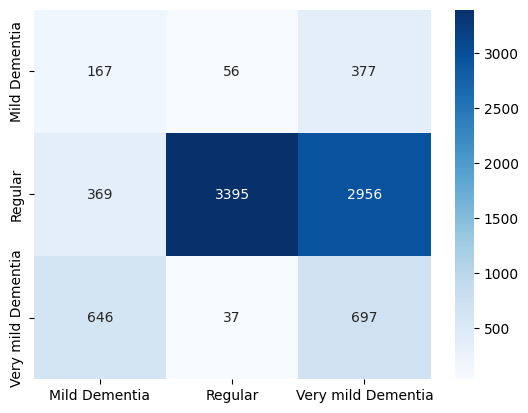

In [ ]:
sn.heatmap(df_cm, annot=True, fmt='', cmap='Blues')

Classification Report

In [ ]:
print(classification_report(labels, predictions, target_names=class_to_idx))

print(labels)
print(predictions)

                    precision    recall  f1-score   support

     Mild Dementia       0.14      0.28      0.19       600
           Regular       0.97      0.51      0.67      6720
Very mild Dementia       0.17      0.51      0.26      1380

          accuracy                           0.49      8700
         macro avg       0.43      0.43      0.37      8700
      weighted avg       0.79      0.49      0.57      8700

[0 0 0 ... 2 2 2]
[[2]
 [2]
 [2]
 ...
 [2]
 [2]
 [2]]


In [ ]:
def calculate_precision():
    precisions = []
    for row in range(4):
        precisions.append(df_cm[row][row] / (df_cm[0][row] + df_cm[1][row] + df_cm[2][row] + df_cm[3][row]))
    
    total_sum = 0
    overall_precision = 0
    for row in range(4):
        row_sum = 0
        for col in range(4):
            row_sum += df_cm[row][col]
        total_sum += row_sum
        overall_precision += precisions[row] * row_sum
    precisions.append(overall_precision / total_sum)
    return precisions

In [ ]:
def calculate_recall():
    recalls = []
    for col in range(4):
        recalls.append(df_cm[col][col] / (df_cm[col][0] + df_cm[col][1] + df_cm[col][2] + df_cm[col][3]))
    
    total_sum = 0
    overall_recall = 0
    for col in range(4):
        col_sum = 0
        for row in range(4):
            col_sum += df_cm[row][col]
        total_sum += col_sum
        overall_recall += recalls[col] * col_sum
    recalls.append(overall_recall / total_sum)
    return recalls

In [ ]:
def calculate_f1(precisions, recalls):
    f1_scores = []
    for i in range(5):
        f1_scores[i] = 2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i])
    return f1_scores

In [ ]:
import pandas as pd
from tabulate import tabulate

# Data for the table
variables = ['Variable 1', 'Variable 2', 'Variable 3', 'Variable 4', 'Variable 5']
percentages = ['20%', '35%', '15%', '10%', '20%']
data = {'Variables': variables, 'Percentages': percentages}

# Create a pandas DataFrame from the data
df = pd.DataFrame(data)

# Convert the DataFrame to a LaTeX table
table = tabulate(df, headers='keys', tablefmt='latex', showindex=False)

# Print the LaTeX table
print(table)

\begin{tabular}{ll}
\hline
 Variables   & Percentages   \\
\hline
 Variable 1  & 20\%           \\
 Variable 2  & 35\%           \\
 Variable 3  & 15\%           \\
 Variable 4  & 10\%           \\
 Variable 5  & 20\%           \\
\hline
\end{tabular}


In [ ]:
def predict_testing_data(model, criterion, device, eval=False):

    ood_dataset = ImageFolder(root='DataOOD', transform= transforms.Compose([transforms.Grayscale()]))
    ood_dataset = CustomDataset(ood_dataset, transform= get_transforms())
    ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=hparams.test_batch_size)

    model.eval()
    pred_loss = 0
    pred_correct = 0
    total_size = 0

    predictions = torch.IntTensor()
    ground_truths = torch.IntTensor()

    predictions, ground_truths = predictions.to(device), ground_truths.to(device)

    with torch.no_grad():
        #for batch_idx, (img, mean, std, target) in enumerate(ood_loader):
            #img, mean, std, target = img.to(device), mean.to(device), std.to(device), target.to(device)
            #output = model(img, mean, std)
            #print(output)
        for batch_idx, (img, target) in enumerate(ood_loader):
            img, target = img.to(device), target.to(device)
            output = model(img)
            loss = criterion(output, target)
            pred_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            print(pred)
            pred_correct += pred.eq(target.view_as(pred)).sum().item()

            predictions = torch.cat((predictions, pred), dim=0)
            ground_truths = torch.cat((ground_truths, target), dim=0)

            total_size += len(img)

    pred_loss /= total_size
    pred_accuracy = 100. * pred_correct / total_size

    if eval:
        return pred_loss, pred_accuracy, predictions.cpu().numpy(), ground_truths.cpu().numpy()
    else:
        return predictions.cpu().numpy(), ground_truths.cpu().numpy()
    
predict_testing_data(model, criterion, device, eval=False)

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='privateuseone:0')
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [1],
        [1]], device='pr

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [1],
        [1]], dtype=int64),
 array([0, 0, 0, 0, 0, 

In [ ]:
!pip install grad-cam


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import cv2

#model = resnet50(pretrained=True)
model = CNN().to(device)
path_to_pt_file = "saved_model\Model 20 (Very Good)\CNN_2023_07_21-22_52_21.pt"
saved_model = torch.load(path_to_pt_file)
model.load_state_dict(saved_model)
target_layers = [list(model.modules())[10]] #change numbers //blue = model not focusing there //red = model is focusing there //error --> dropout layer
path = 'Data\Mild Dementia\OAS1_0028_MR1_mpr-1_100.jpg'

image = Image.open(path)
image = image.convert('L')
input_tensor = get_transforms()(image).unsqueeze(0)
input_tensor = input_tensor.to(device)
rgb_img = cv2.imread(path)
rgb_img = cv2.resize(rgb_img, (248, 248))
rgb_img = np.float32(rgb_img) / 255
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
grayscale_cam = cam(input_tensor, targets=None)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

cv2.imwrite(f'cam.png', visualization)

AxisError: axis 2 is out of bounds for array of dimension 2